# Routing, speed imputation, and travel times (Yönlendirme, hız hesaplama ve seyahat süreleri)

In [1]:
import numpy as np
import osmnx as ox

%matplotlib inline
np.random.seed(0)
ox.__version__

'1.3.0'

In [2]:
place = "Piedmont, California, USA"
G = ox.graph_from_place(place, network_type="drive")
Gp = ox.project_graph(G)

# 1. Fast nearest node/edge search with OSMnx

In [3]:
# randomly sample n points spatially-constrained to the network's geometry
points = ox.utils_geo.sample_points(ox.get_undirected(Gp), n=100)
X = points.x.values
Y = points.y.values
X0 = X.mean()
Y0 = Y.mean()

In [4]:
# find each nearest node to several points, and optionally return distance
# (birkaç noktaya en yakın düğümü bulun ve isteğe bağlı olarak mesafeyi geri getirin)
nodes, dists = ox.nearest_nodes(Gp, X, Y, return_dist=True)

In [5]:
# or, find the nearest node to a single point
# (veya, tek bir noktaya en yakın düğümü bulun)
node = ox.nearest_nodes(Gp, X0, Y0)
node

53021743

In [6]:
# find each nearest edge to several points, and optionally return distance
# (birkaç noktaya en yakın her bir kenarı bulun ve isteğe bağlı olarak mesafeyi geri getirin)
edges, dists = ox.nearest_edges(Gp, X, Y, return_dist=True)

In [7]:
# find the nearest edge to a single point
# (tek bir noktaya en yakın kenarı bul)
edge = ox.nearest_edges(Gp, X0, Y0)
edge

(53085375, 53085377, 1)

# 2. Basic routing by distance (Mesafeye göre temel yönlendirme) 

İki düğüm seçin. Ardından, gidilen mesafeyi en aza indirerek en kısa yolu bulmak için ağırlık='uzunluk' kullanarak başlangıç ve varış noktası arasındaki en kısa yolu bulun (aksi halde her kenarı ağırlık=1 olarak kabul eder).

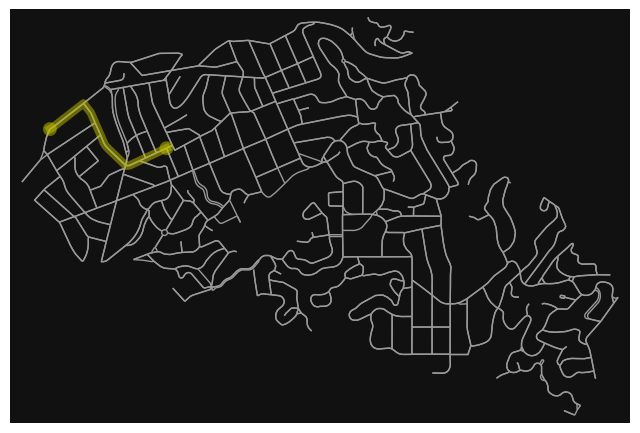

In [8]:
# find the shortest path (by distance) between these nodes then plot it
# (bu düğümler arasındaki en kısa yolu (mesafeye göre) bulun ve çizin)
orig = list(G)[0]
dest = list(G)[120]
route = ox.shortest_path(G, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(G, route, route_color="y", route_linewidth=6, node_size=0)

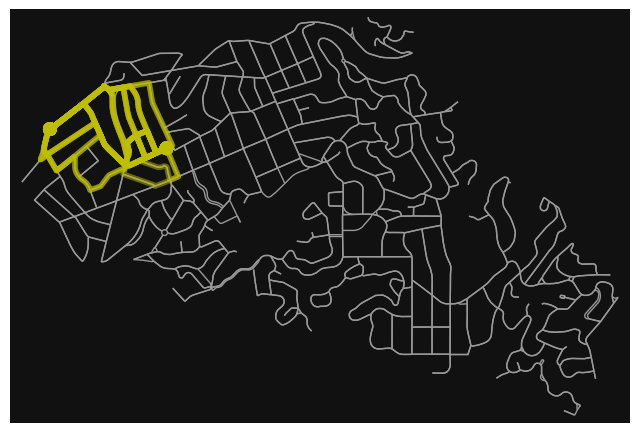

In [9]:
routes = ox.k_shortest_paths(G, orig, dest, k=30, weight="length")
fig, ax = ox.plot_graph_routes(G, list(routes), route_colors="y", route_linewidth=4, node_size=0)

# 3. Imputing travel speeds and times

In [12]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [13]:
# see mean speed/time values by road type
# (yol tipine göre ortalama hız/süre değerlerini görün)
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
residential,123.6,24.1,18.5
secondary,112.4,44.3,9.3
tertiary,104.1,40.2,9.3
tertiary_link,55.6,36.2,5.5
unclassified,28.7,36.2,2.9


In [14]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [15]:
# calculate two routes by minimizing travel distance vs travel time
# (seyahat mesafesini seyahat süresine göre en aza indirerek iki rotayı hesapla)
orig = list(G)[1]
dest = list(G)[120]
route1 = ox.shortest_path(G, orig, dest, weight="length")
route2 = ox.shortest_path(G, orig, dest, weight="travel_time")

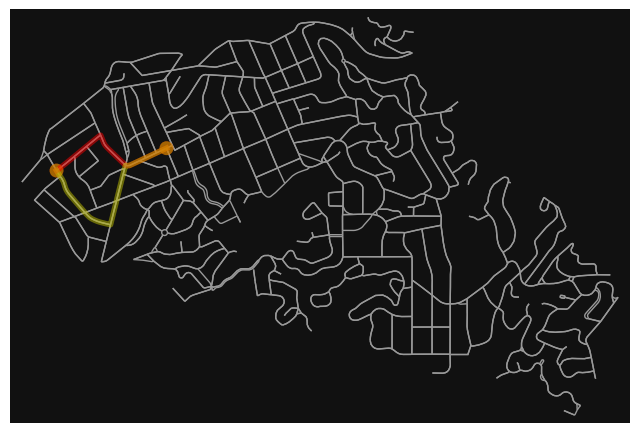

In [18]:
# plot the routes
# (rotaları çiz)
fig, ax = ox.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

In [17]:
# compare the two routes
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "length")))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "travel_time")))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "travel_time")))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

Route 1 is 765 meters and takes 78 seconds.
Route 2 is 1010 meters and takes 77 seconds.


Sarı rota seyahat süresini en aza indirir ve bu nedenle kırmızı rotadan daha uzun ama daha hızlıdır.

# 4. Multiprocessing 

In [19]:
# calculate 100,000 shortest-path routes using random origin-destination pairs
# (rastgele çıkış-varış çiftlerini kullanarak 100.000 en kısa yol rotasını hesapla)
n = 100000
origs = np.random.choice(G.nodes, size=n, replace=True)
dests = np.random.choice(G.nodes, size=n, replace=True)

In [20]:
%%time
# it takes 2.3 seconds to solve all the routes using all the cores on my computer
# I have a 24-thread AMD 5900x: performance will depend on your specific CPU
routes = ox.shortest_path(G, origs, dests, weight="travel_time", cpus=None)

CPU times: total: 2.34 s
Wall time: 13.1 s


In [21]:
%%time
# it takes 29 seconds to solve all the routes using just 1 core on my computer
routes = ox.shortest_path(G, origs, dests, weight="travel_time", cpus=1)

CPU times: total: 36.8 s
Wall time: 36.8 s


In [22]:
# how many total results did we get
print(len(routes))

# and how many were solvable paths
# some will be unsolvable due to directed graph perimeter effects
routes_valid = [r for r in routes if r is not None]
print(len(routes_valid))

100000
99143


# 5. Miscellaneous routing notes (Çeşitli yönlendirme notları) 

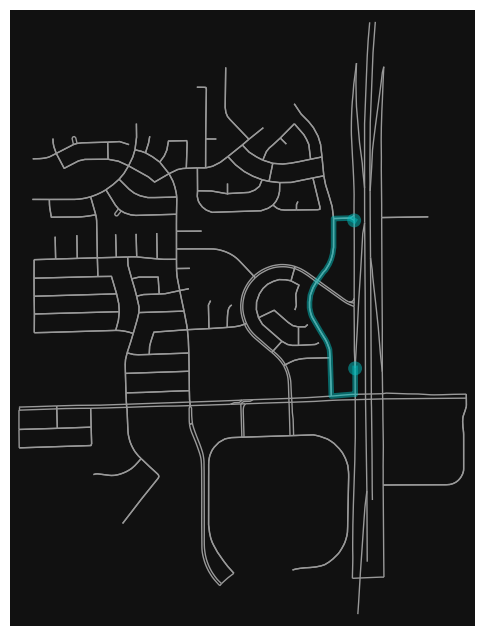

In [23]:
G2 = ox.graph_from_address(
    "N. Sicily Pl., Chandler, Arizona",
    dist=800,
    network_type="drive",
    truncate_by_edge=True,
)
origin = (33.307792, -111.894940)
destination = (33.312994, -111.894998)
origin_node = ox.distance.nearest_nodes(G2, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(G2, destination[1], destination[0])
route = ox.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G2, route, route_color="c", node_size=0)

Ayrıca rotadaki düğümler arasında paralel kenarlar olduğunda, OSMnx çizilecek en kısa kenarı seçer:

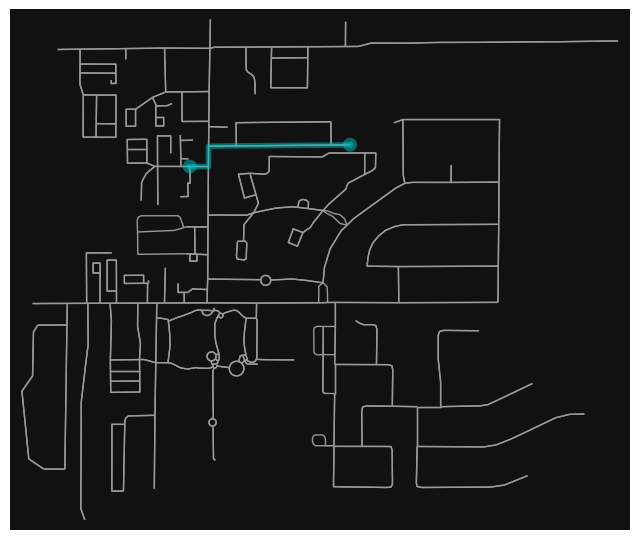

In [24]:
location_point = (33.299896, -111.831638)
G2 = ox.graph_from_point(location_point, dist=400, truncate_by_edge=True)
origin = (33.301821, -111.829871)
destination = (33.301402, -111.833108)
origin_node = ox.distance.nearest_nodes(G2, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(G2, destination[1], destination[0])
route = ox.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G2, route, route_color="c", node_size=0)